In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


# Clasificación de imágenes: Cat vs. Dog (of course!)
## Ejercicio 1: Nuestra primera Convnet desde cero
**_Tiempo estimado: 20 minutos_**

En este ejercicio, vamos a construir nuestro clasificador de perros o gatos desde cero. Para ello seguiremos los siguientes pasos:

1. Explorar los datos
2. Construir una convnet desde cero capaz de resolver nuestro problema de clasificación
3. Evaluar nuestra red tanto en entrenamiento como en validación

A por ello!

## Explorando los datos!

Vamos a empezar descargando nuestros datos, un .zip de 2.000 imágenes de perros y gatos en JPG, y descargándolo en '/tmp'.

**NOTA:** Las 2.000 imagenes utilizadas en este ejercicio se han extraído de la base de datos ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible en Kaggle, la cual contiene 25.000 imágenes. Nosotros vamos a utilizar un subset para agilizar el aprendizaje.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# !curl https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -o .\tmp\cats_and_dogs_filtered.zip

--2021-10-25 16:12:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   138MB/s    in 0.5s    

2021-10-25 16:12:46 (138 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

A continuación extraemos los contenidos del .zip en el path `/tmp/cats_and_dogs_filtered`. Contiene dos subdirectorios, `train` y `validation` con dichos datasets. Dentro de cada uno de estos directorios tenemos los directorios `cats` y `dogs` con las imágnes.

Podéis ver [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) si necesitáis refrescar los conceptos de entrenamiento, validación y test. 

Vamos a definir estos directorios.

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio con nuestras imágenes de train de gatos
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorio con nuestras imágenes de train de perros
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con nuestras imágenes de validación de gatos
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directorio con nuestras imágenes de validación de perros
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Ahora vamos a ver qué pinta tienen nuestros ficheros, empezamos imprimiendo los nombres de fichero de unos cuantos:

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.890.jpg', 'cat.309.jpg', 'cat.585.jpg', 'cat.997.jpg', 'cat.145.jpg', 'cat.438.jpg', 'cat.697.jpg', 'cat.153.jpg', 'cat.423.jpg', 'cat.218.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


A continuación vamos a ver cuál es el total de imágenes que tenemos de cada tipo:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


Como podemos ver, tenemos un total de 1000 imágenes de entrenamiento y 500 imágenes de test tanto de perros como de gatos.

Siempre es recomendable asegurarnos de que los datos están bien y coger un poco de intuición acerca de cómo son. Vamos a imprimir unas cuantas imágenes!

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Vamos a imprimir imágenes en un grid de 4x4
nrows = 4
ncols = 4

# Índice para iterar por las imágenes
pic_index = 0

Vamos a imprimir 8 imágenes de cada. Son aleatorias por lo que podéis volver a correr la celda para ver otro batch las veces que queráis.

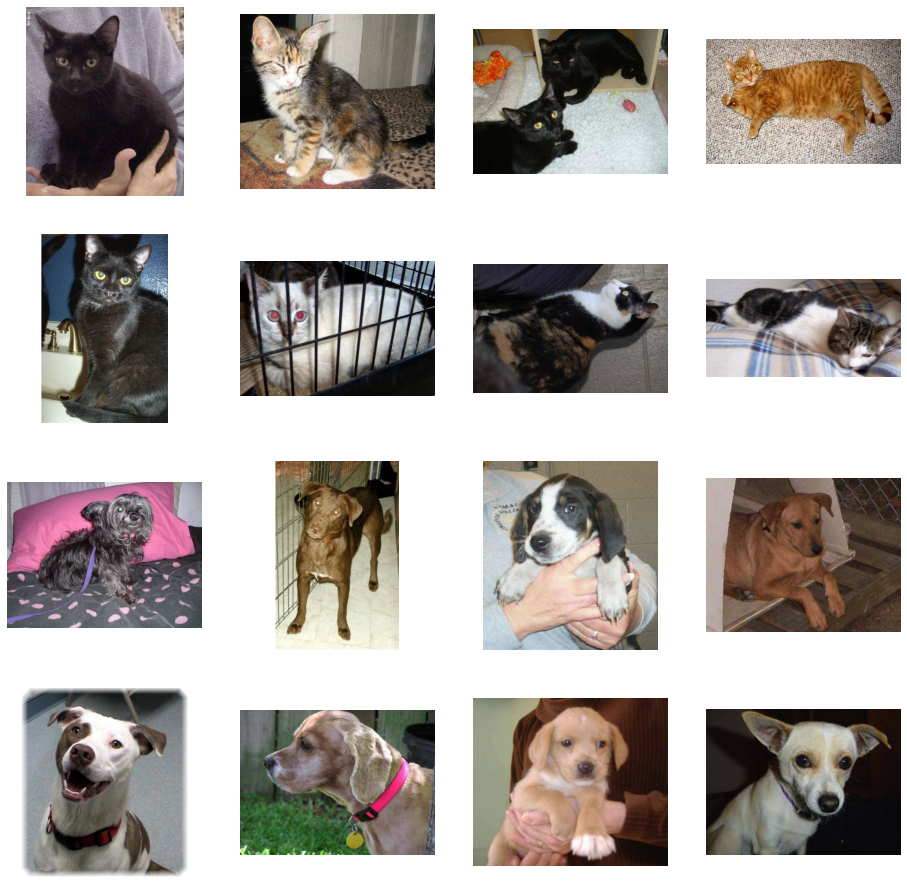

In [ ]:
# Configuramos una fig. de matplotlib para ajustarse a 4x4 imágenes
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Ajustamos los subplot
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # No mostramos líneas en los ejes

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Construyendo una pequeña CNN desde cero, objetivo, 72% de Accuracy

Las imágenes que entrarán en nuestra CNN son de tamaño 150x150 y son a color (en la siguiente sección, en Data Preprocessing, vamos a procesar las imágenes para que se ajusten a esto).

Vamos a configurar nuestra arquitectura!. Vamos a utilizar "stacks" de 3 módulos {convolución + relu + maxpooling}. Nuestras convoluciones van a operar con filtros de tamaño 3x3 y nuestra maxpooling con filtros de tamaño 2x2. Nuestra primera convolución va a extraer 16 filtros, la siguiente 32 y la última 64 filtros.

**NOTE**: Esta es una configuración ampliamente conocida por funcionar bien para clasificación de imágenes. Además, como tenemos pocos datos de entrenamiento, utilizar sólo 3 stacks convolucionales da lugar a un modelo pequeño, evitando problemas de overfitting (que estudiaremos en el ejercicio 2.)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Nuestro feature map de entrada es de 150x150x3, con 150x150 píxels y 3 canales (RGB)
img_input = layers.Input(shape=(150, 150, 3))

# La primera convolución extrae 16 filtros de 3x3, relu va diréctamente embebido en esta capa
# La convolución va seguida, en este caso, de una capa de max-pooling con ventanas de 2x2
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# TODO 1: Crear una segunda capa convolucional seguida de una MaxPooling2D
# Recuerda que esta convolución debería extraer 32 filtros de 3x3
# Utilizaremos a continuación una capa MaxPooling2D con tamaño de ventana 2x2
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# La tercera convolución extraer 64 filtros de tamaño 3x3 y va seguida de otra MaxPooling2D de 2x2.
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

A continuación vamos a añadir dos capas fully-connected. Al estar trabajando con un problema de clasificación binaria (2 clases), terminaremos con una capa de salida con una neurona con función de activación [*sigmoid*](https://wikipedia.org/wiki/Sigmoid_function), de forma que nuestra salida será un escalar entre 0 y 1, que será la probabilidad de que nuestra imágen de entrada sea de la clase 1.

In [ ]:
# TODO 2: Aplana "Flatten" la salida de la capa precedente
# Aplana el feature map a un tensor de 1 dimensión para añadir nuestras capas fully connected
x = layers.Flatten()(x)

# TODO 3: Crea una capa fully-connected (dense)
# Crea una capa fully-connected con función de activación ReLU y 512 neuronas
x = layers.Dense(512, activation='relu')(x)

# Creamos la capa de salida con un sólo nodo y función de activación sigmoide
output = layers.Dense(1, activation='sigmoid')(x)

# Por último, creamos el modelo:
# input = input feature map (en nuestro caso las imágenes)
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

Vamos a ver un resúmen de nuestra arquitectura:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0     

La columna "output shape" nos muestra cómo evoluciona el tamaño de nuestro feature map capa a capa. Las capas de convolución reducen el tamaño del feature map debido al padding. Las capas de pooling reducen el feature map a la mitad.

A continuación, vamos a configurar las especificaciones de entrenamiento de nuestro modelo. Vamos a utilizar la función de coste `binary_crossentropy`, ya que estamos ante un problema de clasificación binaria con función de activación sigmoide (os acordáis de logistic regressión?). Usaremos el optimizador `rmsprop` con un learning rate de `0.001`. Durante el entrenamiento, vamos a monitorizar además de la función de coste el accuracy.

**NOTE**: En este caso, es preferible usar [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) frente a [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), porque RMSprop automatiza el ajuste del learning-rate por nosotros. Otros optimizadores como [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) o [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), también automatizan la adaptación del lr y funcionarían también bien aquí.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Data Preprocessing

Vamos a configurar generadores que puedan leer las imágenes de nuestras carpetas, convertirlas a tensores de `float32` y utilizarlas para alimentar (junto con sus etiquetas) nuestra red. Tendremos generadores separados para train y test. Nuestros generadores van a utilizar batches de 20 imágenes de tamaño 150x150 con sus etiquetas.

Como ya sabes, los datos suelen normalizarse antes de entrar a la red neuronal. En nuestro caso, al trabajar con imágenes con valores de píxel en el rango `[0, 255]` vamos a normalizarlas al rango `[0, 1]`.

En Keras podemos hacer esto con la clase `keras.preprocessing.image.ImageDataGenerator`, utilizando el parámetro `rescale`. Esta clase te permite instanciar generadores de batches de imágenes "augmentadas" mediante `.flow(data, labels)` o `.flow_from_directory(directory)`. Estos generadores pueden después utilizarse en cualquier modelo que acepte generadores de datos como entrada: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reescalamos las imágenes al rango [0,1]
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Preparamos las imágenes en batches de 20 utilizando el generador train_datagen
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Directorio donde tenemos nuestros datos
        target_size=(150, 150),  # Las imágenes se van a reescalar a tamaño 150x150
        batch_size=20,
        # Como utilizamos la función de coste binary_crossentropy loss, necesitamos etiquetas binarias
        class_mode='binary')

# Hacemos lo mismo con los datos de validación
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training

Vamos a entrenar con las 2000 imágenes disponibles, durante 15 épocas, y a validar con todas nuestras imágenes de validación.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
100/100 - 13s - loss: 0.8598 - acc: 0.5545 - val_loss: 0.6584 - val_acc: 0.5960
Epoch 2/15
100/100 - 10s - loss: 0.6356 - acc: 0.6645 - val_loss: 0.5885 - val_acc: 0.6840
Epoch 3/15
100/100 - 10s - loss: 0.5705 - acc: 0.7100 - val_loss: 0.5877 - val_acc: 0.7000
Epoch 4/15
100/100 - 10s - loss: 0.4989 - acc: 0.7635 - val_loss: 0.5749 - val_acc: 0.7050
Epoch 5/15
100/100 - 10s - loss: 0.4295 - acc: 0.7935 - val_loss: 0.6363 - val_acc: 0.7050
Epoch 6/15
100/100 - 10s - loss: 0.3539 - acc: 0.8445 - val_loss: 0.7498 - val_acc: 0.6790
Epoch 7/15
100/100 - 10s - loss: 0.2727 - acc: 0.8815 - val_loss: 0.7375 - val_acc: 0.7070
Epoch 8/15
100/100 - 10s - loss: 0.2033 - acc: 0.9165 - val_loss: 0.8188 - val_acc: 0.6910
Epoch 9/15
100/100 - 10s - loss: 0.1412 - acc: 0.9425 - val_loss: 1.0267 - val_acc: 0.7170
Epoch 10/15
100/100 - 10s - loss: 0.1094 - acc: 0.9585 - val_loss: 0.9874 - val_acc: 0.7200
Epoch 11/15
100/100 - 10s - loss: 0.0822 - acc: 0.9745 - val_loss: 1.1924 - val_acc: 0.71

### Visualizando representaciones intermedias

Para tener una noción del tipo de características que nuestra CNN ha aprendido, podemos visualizar cómo nuestra entrada va transformándose a medida que pasa por la red.

Vamos a coger una foto aleatoria de nuestro conjunto de entrenamiento y a generar una figura donde cada fila es la salida de una capa, y cada imagen en la fila es un filtro específico en dicho feature map de salida. Podemos vovler a correr esta celda para generar representaciones intermedias de otras imágenes.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


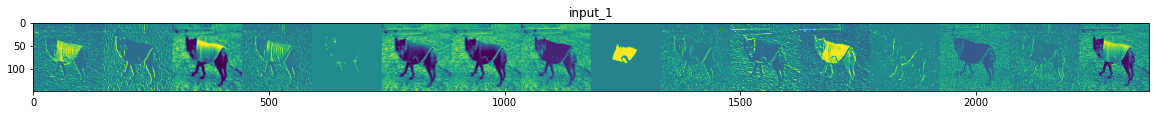

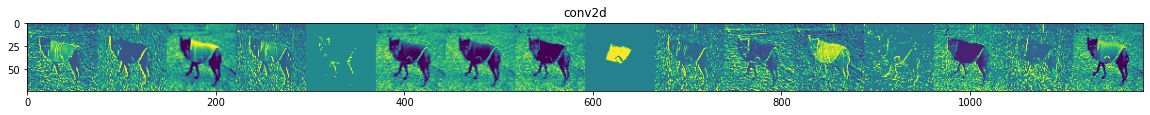

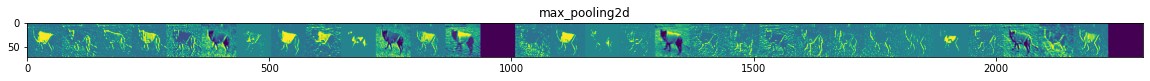

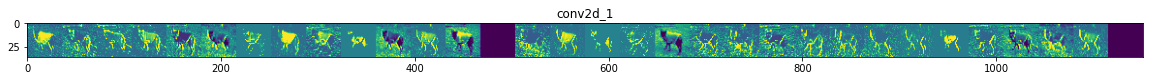

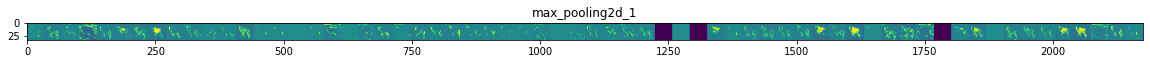

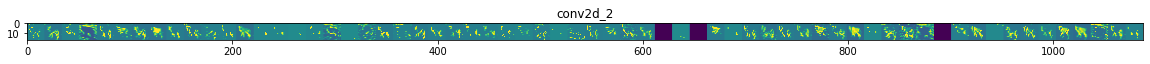

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img


# Empezamos definiendo un nuevo modelo que va a coger una imagen como entrada y tendrá como salida la
# representación intermeda de todas las capas del modelo.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Preparamos una imágen aleatoria de gato o perro para nuestro experimento
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150)) 
x = img_to_array(img)  # Numpy array con shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array con shape (1, 150, 150, 3)

# Reescalamos dividiendo por 1/255
x /= 255

# Vamos a hacer pasar nuestra imágen a través de la red para obtener estas representaciones intermedias
successive_feature_maps = visualization_model.predict(x)

# Estos son lo snombres de las capas, para poder utilizarlas en nuestro plot
layer_names = [layer.name for layer in model.layers]

# Ahora ya podemos plotear nuestras representaciones intermedias!
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Hacemos esto sólo para las capas conv/maxpool, no para las dense 
    n_features = feature_map.shape[-1]  # número de features en el feature map
    # El feature map tendrá un shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # Ajustamos nuestras imágenes en el grid
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocesado del feature map para que quede mejor visualmente
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Metemos todo en el grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Mostramos el grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Como puedes ver, avanzamos desde los píxeles en crudo de la imagen hasta representaciones cada vez más abstractas y compactas. Las representaciones muestran aquello en que la red se fija con más atención, mostrando cada vez menos features "activadas", de hecho la mayoría serán 0. A esto se le conoce como "sparsity". Una representación "sparse" es una de las características clave en deep learning.

Estas representaciones van perdiendo información presente en los píxeles de la imagen. Sin embargo, van refinando la información sobre la clase de la imagen. Puedes pensar en una CNN (o en una DNN en general) como un sistema de destilación de información.

### Evaluando el Accuracy y la función de coste del modelo

Vamos a representar el accuracy y la función de coste tanto de entrenamiento como de validación:

Text(0.5, 1.0, 'Training and validation loss')

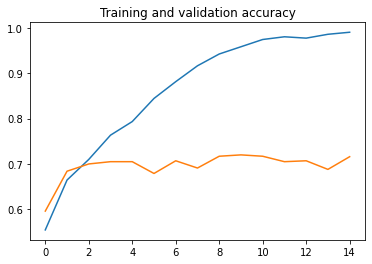

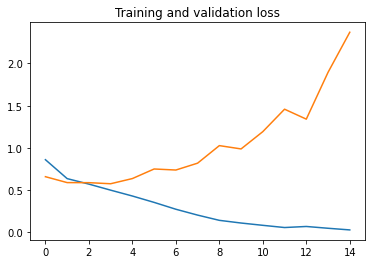

In [ ]:
# Podemos extraer los valores de accuracy y loss del histórico que se ha guardado al entrenar la red
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extraemos el número de epochs
epochs = range(len(acc))

# Representamos con plot nuestro accuracy por epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Representamos con plot nuestro loss por epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Como podeis ver, estamos ante un problema de **overfitting**. Nuestra curva de entrenamiento (en azul) se acerca a 100% (!) mientras que nuestra validación (en verde) se queda en 70%. De hecho el loss de validación alcanza el mínimo en cinco épocas.

Como tenemos un número relativamente pequeño de muestras de entrenamiento (2000), tenemos que tener mucho cuidado con sobreentrenar nuestro modelo. Esto sucede cuando el modelo, en lugar de aprender características generales, "memoriza" nuestros datos de entrenamiento o características de estos que no nos ayudan a generalizar. Por ejemplo, si tú, como humano, sólo ves 3 imágenes de leñadores y 3 imágenes de marineros, y entre ellas la única persona que lleva un gorro rojo es leñador, puedes empezar a pensar que llevar un gorro rojo es un signo de ser un leñador. Habrías aprendido una característica de tus datos de entrenamiento que no es aplicable a nuevos datos.

El sobreentrenamiento es el problema central de Machine Learning: dado que estamos ajustando los parámetros del modelo a un dataset en concreto, ¿cómo podemos asegurarnos de que las representaciones aprendidas por el modelo serán aplicables a datos que nunca se han visto ántes?. ¿Cómo evitamos aprender cosas que son sólo específicas del conjunto de entrenamiento?.

En el siguiente ejercicio vamos a ver cómo podríamos enfrentarnos al problema del sobreajuste, sobreentrenamiento o overfitting en el problema de clasificación de gatos y perros.

## Clean Up

Antes de correr el siguiente ejercicio, corre la sigueinte celda para finalizar el kernel y liberar la memoria.

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)